# **Trabajo Práctico II**
___________________________________________________________________________
### *Visión Por Computadora I*                                   
### *Facultad de Ingeniería de la Universidad de Buenos Aires*
### *Laboratorios de Sistemas Embebidos*                                                 
### D. Canal, G. Schvarchman, F. Zoya
___________________________________________________________________________

# **Consigna de trabajo**

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que qutilizan las cámaras dígitales modernas. El video a procesar será: "focus_video.mov".

1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propiesta en e paper "image Sharpeness Measure for Blurred Images in Frequency Domain" y realizar dos experimentos:

  I. Medición sobre todo el frame.

  II. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10 % del área total del frame.

Para cada experimento se debe presentar:

  - Una curva o varias curvas que muestren la evolución de la métrica frame donde se vea claramente cuando el algoritmo detecto el puntode máximo enfoque.

El algoritmo de deteción a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

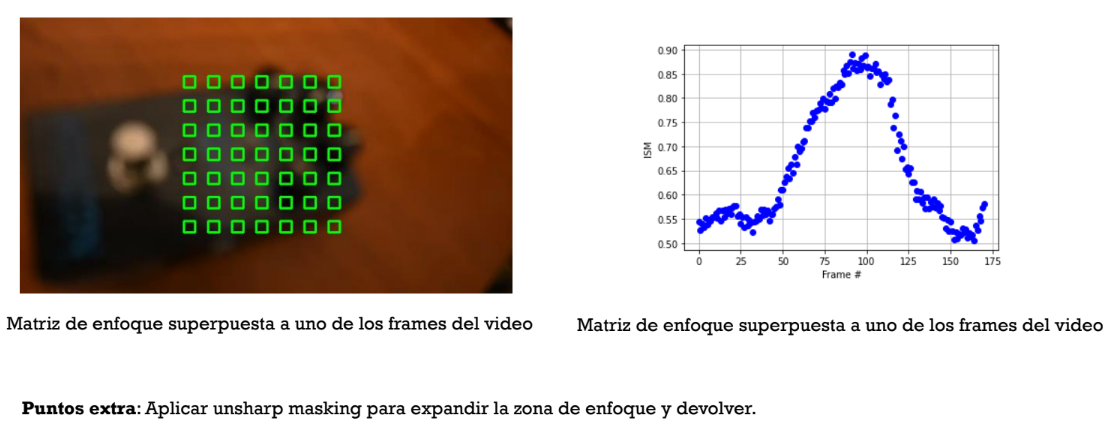

# **Desarrollo**
---

In [2]:
# Import of required libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow

## **Carga del video**
---

In [4]:
path   = "./files/focus_video.mov"
cap    = cv.VideoCapture(path)
frames = []

while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    break
  gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
  frames.append(gray)

cap.release()
print(f"Total de frames cargados: {len(frames)}")

Total de frames cargados: 171


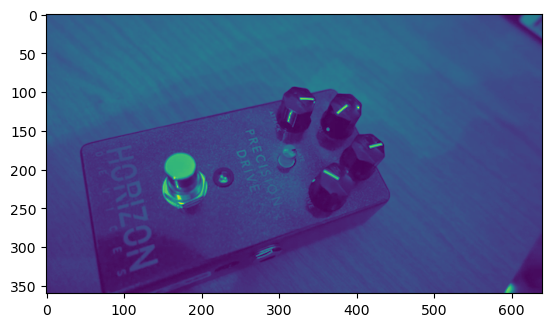

In [6]:
plt.imshow(frames[109])

In [7]:
"""
Métrica imple que limina las bajas frecuencias centrales (correspondientes al desenfoque)
"""
def sharpness_fft(img):
  f = np.fft.fft2(img)
  fshift = np.fft.fftshift(f)
  magnitude_spectrum = np.abs(fshift)

  # Enmascarar baja frecuencia (central)
  h, w = img.shape
  center_h, center_w = h//2, w//2
  magnitude_spectrum[center_h-10:center_h+10, center_w-10:center_w+10] = 0

  sharpness_score = np.sum(magnitude_spectrum)
  return sharpness_score

In [8]:
"""
Métrica propuesta en el paper que mide el número de componentes de alta
frecuencia que supera un umbral relativo
"""
def sharpness_FW(img):
  """
  Calcula la métrica de nitidez FM según el paper:
  'Image Sharpness Measure for Blurred Images in Frequency Domain'
  """
  f  = np.fft.fft2(img)
  fc = np.fft.fftshift(f)
  af = np.abs(fc)

  M = np.max(af)
  threshold = M / 1000

  high_freq_count = np.sum(af > threshold)
  total_pixels    = af.shape[0] * af.shape[1]

  fm = high_freq_count / total_pixels
  return fm

## **Experimento I: "Medición sobre todo el frame"**
---


In [9]:
# Procesamos el video frame por frame
sharpness_fft_values = [sharpness_fft(f) for f in frames]
sharpness_FW_values  = [sharpness_FW(f) for f in frames]

max_index_fft = np.argmax(sharpness_fft_values)
max_index_FM  = np.argmax(sharpness_FW_values)

print(f"Frame con mayor enfoque (FFT): {max_index_fft}")
print(f"Frame con mayor enfoque (FM): {max_index_FM}")

Frame con mayor enfoque (FFT): 111
Frame con mayor enfoque (FM): 109


### *Visulaización de resultados*

NameError: name 'color_frames' is not defined

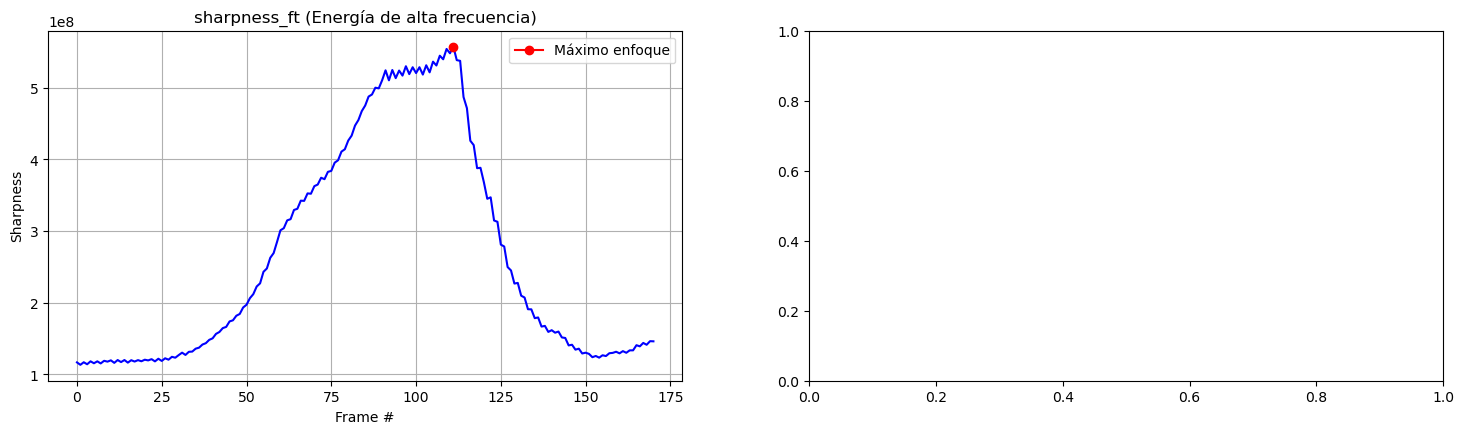

In [10]:
plt.figure(figsize=(18, 10))

# Subplot 1: curva sharpness_fft
plt.subplot(2, 2, 1)
plt.plot(sharpness_fft_values, color = 'blue')
plt.plot(max_index_fft,max(sharpness_fft_values), color = 'red', marker = 'o', label = "Máximo enfoque")
plt.title("sharpness_ft (Energía de alta frecuencia)")
plt.xlabel("Frame #")
plt.ylabel("Sharpness")
plt.legend(loc = 'best')
plt.grid(True)

# Subplot 2: frame más enfocado según  shapness_fft
plt.subplot(2, 2, 2)
plt.imshow(color_frames[max_index_fft])
plt.title(f"Máximo enfoque: #{max_index_fft}")
plt.axis('off')

# Subplot 3: Curva sharpness_FM
plt.subplot(2, 2, 3)
plt.plot(sharpness_FW_values, color = 'green')
plt.plot(max_index_FM,max(sharpness_FW_values), color = 'red', marker = 'o', label = "Máximo enfoque")
plt.title("sharpness_FM (Métrica del paper)")
plt.xlabel("Frame #")
plt.ylabel("FM")
plt.legend(loc = 'best')
plt.grid(True)

# Subplot 4: frame más enfocado según  shapness_FW
plt.subplot(2, 2, 4)
plt.imshow(color_frames[max_index_FM])
plt.title(f"Máximo enfoque: #{max_index_FM}")
plt.axis('off')

## **Experimento II.1: "Medición de enfoque solo en la ROI central (5%)"**
---
Se aplicó las métricas solo en la región central (5% de área) de cada frame para evitar influencias de los bordes

In [11]:
# Función qu eextra el percent dela zona central
def get_central_roi (img, percent):
  h, w = img.shape
  roi_h, roi_w = int(h * percent), int(w * percent)
  y1 = h//2 - roi_h//2
  x1 = w//2 - roi_w//2
  return img[y1:y1+roi_h, x1:x1+roi_w]

In [12]:
# Procesamos nuevamente el video
cap = cv.VideoCapture(path)
frames = []

while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    break
  gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
  frames.append(gray)

cap.release()

In [13]:
# Procesamos el video frame por frame
sharpness_fft_values_roi = [sharpness_fft(get_central_roi (f,0.05)) for f in frames]
sharpness_FW_values_roi  = [sharpness_FW(get_central_roi (f,0.05)) for f in frames]

max_index_fft_roi = np.argmax(sharpness_fft_values_roi)
max_index_FM_roi  = np.argmax(sharpness_FW_values_roi)

print(f"Frame con mayor enfoque (FFT): {max_index_fft_roi}")
print(f"Frame con mayor enfoque (FM): {max_index_FM_roi}")

Frame con mayor enfoque (FFT): 99
Frame con mayor enfoque (FM): 95


### *Visulaización de resultados*

In [14]:
# Cargamos la imagen en colores
cap    = cv.VideoCapture(path)
color_frames = []

while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    break
  color = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
  color_frames.append(color)

cap.release()
print(f"Total de frames cargados: {len(color_frames)}")

Total de frames cargados: 171


(np.float64(-0.5), np.float64(639.5), np.float64(359.5), np.float64(-0.5))

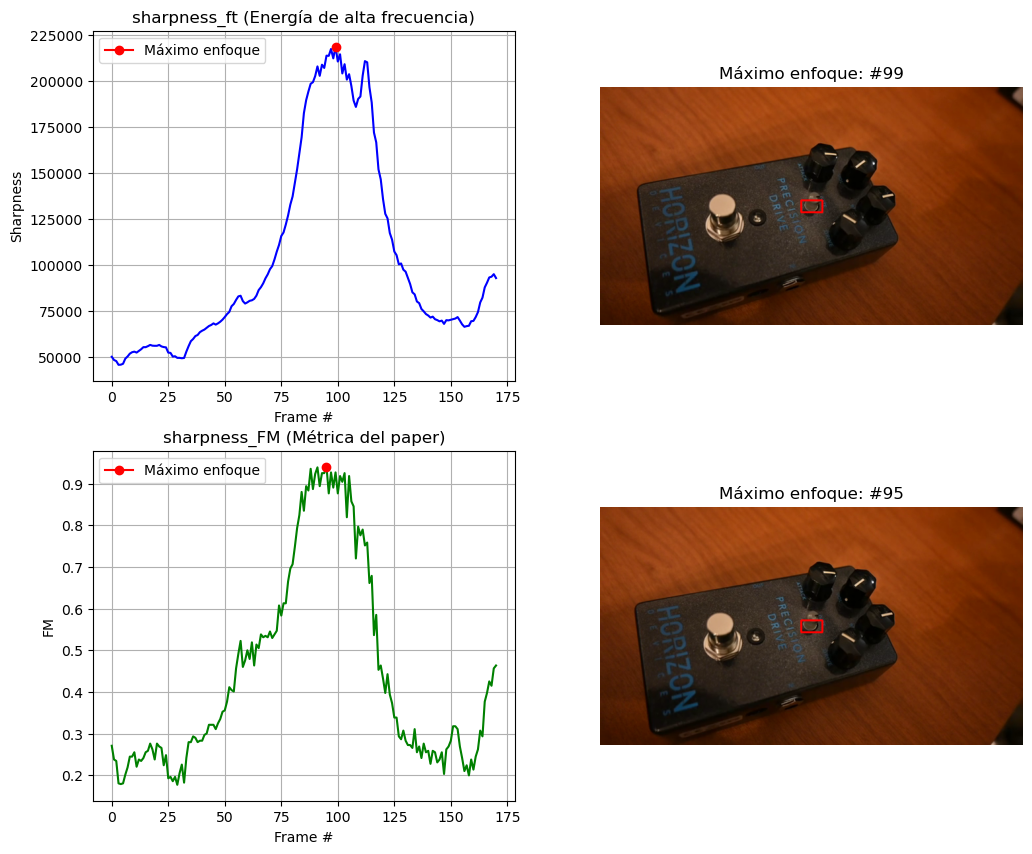

In [15]:


plt.figure(figsize=(12, 10))

# Subplot 1: curva sharpness_fft
plt.subplot(2, 2, 1)
plt.plot(sharpness_fft_values_roi, color = 'blue')
plt.plot(max_index_fft_roi,max(sharpness_fft_values_roi), color = 'red', marker = 'o', label = "Máximo enfoque")
plt.title("sharpness_ft (Energía de alta frecuencia)")
plt.xlabel("Frame #")
plt.ylabel("Sharpness")
plt.legend(loc = 'best')
plt.grid(True)

# Subplot 2: frame más enfocado según  shapness_fft
plt.subplot(2, 2, 2)
img_fft = color_frames[max_index_fft_roi].copy()
#  Obtener las dimensiones del ROI usando la forma del ROI devuelto
roi = get_central_roi(frames[max_index_fft_roi], 0.05)
h, w = roi.shape
#  Calcular las coordenadas de la esquina superior izquierda del ROI
y = frames[max_index_fft_roi].shape[0]//2 - h//2
x = frames[max_index_fft_roi].shape[1]//2 - w//2
#  Dibujar el rectángulo en la imagen original
cv.rectangle(img_fft, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Azul
plt.imshow(img_fft)
plt.title(f"Máximo enfoque: #{max_index_fft_roi}")
plt.axis('off')

# Subplot 3: Curva sharpness_FM
plt.subplot(2, 2, 3)
plt.plot(sharpness_FW_values_roi, color = 'green')
plt.plot(max_index_FM_roi,max(sharpness_FW_values_roi), color = 'red', marker = 'o', label = "Máximo enfoque")
plt.title("sharpness_FM (Métrica del paper)")
plt.xlabel("Frame #")
plt.ylabel("FM")
plt.legend(loc = 'best')
plt.grid(True)

# Subplot 4: frame más enfocado según  shapness_FW
plt.subplot(2, 2, 4)
img_FW = color_frames[max_index_FM_roi].copy()
#  Obtener las dimensiones del ROI usando la forma del ROI devuelto
roi = get_central_roi(frames[max_index_FM_roi], 0.05)
h, w = roi.shape
#  Calcular las coordenadas de la esquina superior izquierda del ROI
y = frames[max_index_FM_roi].shape[0]//2 - h//2
x = frames[max_index_FM_roi].shape[1]//2 - w//2
#  Dibujar el rectángulo en la imagen original
cv.rectangle(img_FW, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Azul
plt.imshow(img_FW)
plt.title(f"Máximo enfoque: #{max_index_FM_roi}")
plt.axis('off')

## **Experimento II.2: "Medición de enfoque solo en la ROI central (10%)"**
---
Igual que el punto II.1, salvo que consideramos el 10% del área central

In [16]:
# Procesamos nuevamente el video
cap = cv.VideoCapture(path)
frames = []

while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    break
  gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
  frames.append(gray)

cap.release()

sharpness_fft_values_roi = []
sharpness_FW_values_roi = []

In [17]:
# Procesamos el video frame por frame
sharpness_fft_values_roi = [sharpness_fft(get_central_roi (f,0.1)) for f in frames]
sharpness_FW_values_roi  = [sharpness_FW(get_central_roi (f,0.1)) for f in frames]

max_index_fft_roi = np.argmax(sharpness_fft_values_roi)
max_index_FM_roi  = np.argmax(sharpness_FW_values_roi)

print(f"Frame con mayor enfoque (FFT): {max_index_fft_roi}")
print(f"Frame con mayor enfoque (FM): {max_index_FM_roi}")

Frame con mayor enfoque (FFT): 101
Frame con mayor enfoque (FM): 91


### *Visulaización de resultados*

(np.float64(-0.5), np.float64(639.5), np.float64(359.5), np.float64(-0.5))

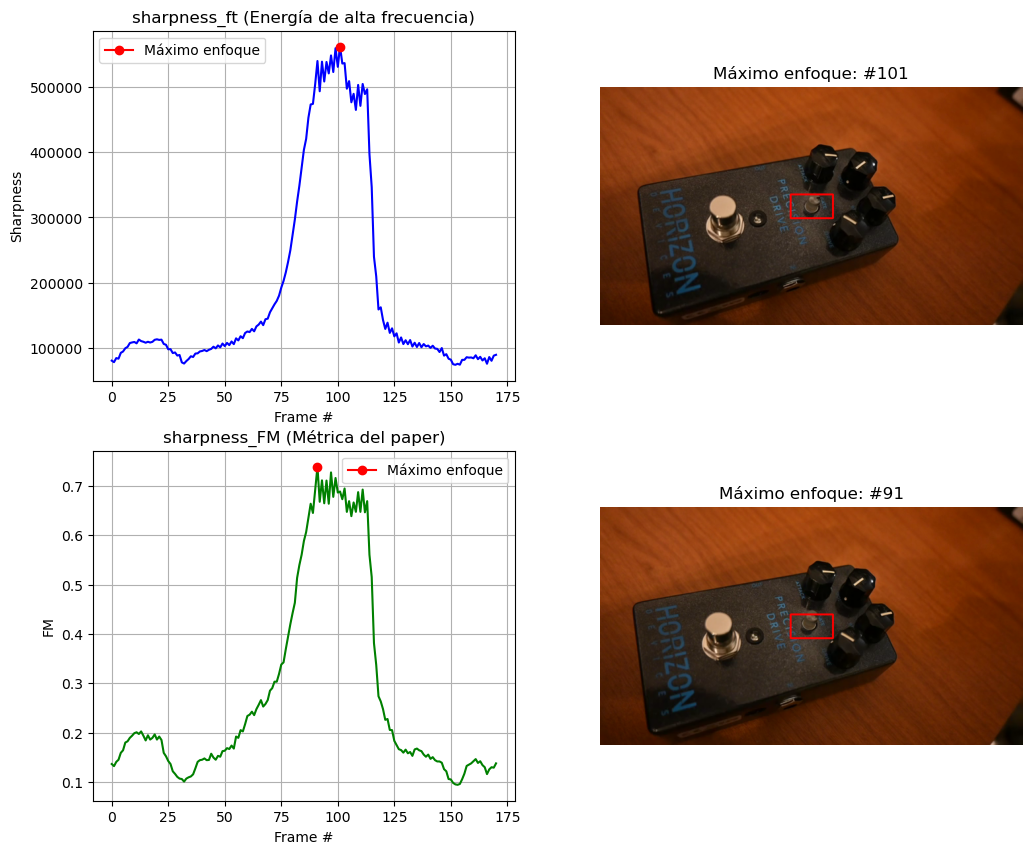

In [18]:
plt.figure(figsize=(12, 10))

# Subplot 1: curva sharpness_fft
plt.subplot(2, 2, 1)
plt.plot(sharpness_fft_values_roi, color = 'blue')
plt.plot(max_index_fft_roi,max(sharpness_fft_values_roi), color = 'red', marker = 'o', label = "Máximo enfoque")
plt.title("sharpness_ft (Energía de alta frecuencia)")
plt.xlabel("Frame #")
plt.ylabel("Sharpness")
plt.legend(loc = 'best')
plt.grid(True)

# Subplot 2: frame más enfocado según  shapness_fft
plt.subplot(2, 2, 2)
img_fft = color_frames[max_index_fft_roi].copy()
#  Obtener las dimensiones del ROI usando la forma del ROI devuelto
roi = get_central_roi(frames[max_index_fft_roi], 0.10)
h, w = roi.shape
#  Calcular las coordenadas de la esquina superior izquierda del ROI
y = frames[max_index_fft_roi].shape[0]//2 - h//2
x = frames[max_index_fft_roi].shape[1]//2 - w//2
#  Dibujar el rectángulo en la imagen original
cv.rectangle(img_fft, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Azul
plt.imshow(img_fft)
plt.title(f"Máximo enfoque: #{max_index_fft_roi}")
plt.axis('off')

# Subplot 3: Curva sharpness_FM
plt.subplot(2, 2, 3)
plt.plot(sharpness_FW_values_roi, color = 'green')
plt.plot(max_index_FM_roi,max(sharpness_FW_values_roi), color = 'red', marker = 'o', label = "Máximo enfoque")
plt.title("sharpness_FM (Métrica del paper)")
plt.xlabel("Frame #")
plt.ylabel("FM")
plt.legend(loc = 'best')
plt.grid(True)

# Subplot 4: frame más enfocado según  shapness_FW
plt.subplot(2, 2, 4)
img_FW = color_frames[max_index_FM_roi].copy()
#  Obtener las dimensiones del ROI usando la forma del ROI devuelto
roi = get_central_roi(frames[max_index_FM_roi], 0.10)
h, w = roi.shape
#  Calcular las coordenadas de la esquina superior izquierda del ROI
y = frames[max_index_FM_roi].shape[0]//2 - h//2
x = frames[max_index_FM_roi].shape[1]//2 - w//2
#  Dibujar el rectángulo en la imagen original
cv.rectangle(img_FW, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Azul
plt.imshow(img_FW)
plt.title(f"Máximo enfoque: #{max_index_FM_roi}")
plt.axis('off')

## **Bonus: "Unsharp masking"**
---
En este apartado se utiliza la técnica de sharpening para mejorar visualmente la zona de enfoque, cambiando la imagen original con una versión más suavizada y de esta forma hacerla más nitida.

El proceso se basa en resaltar los bordes de una imagen y se puede dividi en tres pasos:

1. Se desenfoca la imagen original usando un filtro Gaussiano, generando una versión borrosa.
2. Se resalta la imagen borrrosa a la imagen original, obteniendo una "máscara de bordes" (solo detalles finos).
3. Se suma esa máscara de detalles multiplicada por un factor (alpha) a la imagen original, haciendo que los bordes se vean más fuertes.

**Fórmula básica**

Si I es la imagen original y B es la imagen borrosa (blurred), entonces:

```
sharpened = I  + α(I- B)

donde:

* α es un párametro de intensidad de realce.
* I - B real sa lo bordes
```

In [19]:
def unsharp_mask(img, alpha=1.5, kernel_size=(5, 5), sigma=1.0):
  """
  Applies the Unsharp Masking filter to a grayscale image
  """
  blurred = cv.GaussianBlur(img, kernel_size, sigma)
  sharpened = cv.addWeighted(img, alpha, blurred, 1 - alpha, 0)
  return sharpened

In [20]:
# Procesamos nuevamente el video
cap = cv.VideoCapture(path)
frames = []

while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    break
  gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
  frames.append(gray)

cap.release()

In [21]:
# Procesamos el video frame por frame
mask_sharpness_FW_values  = [sharpness_FW(unsharp_mask(f)) for f in frames]

max_index_FM  = np.argmax(mask_sharpness_FW_values)

print(f"Frame con mayor enfoque (FM): {max_index_FM}")

Frame con mayor enfoque (FM): 109


### *Visulaización de resultados*

(np.float64(-0.5), np.float64(639.5), np.float64(359.5), np.float64(-0.5))

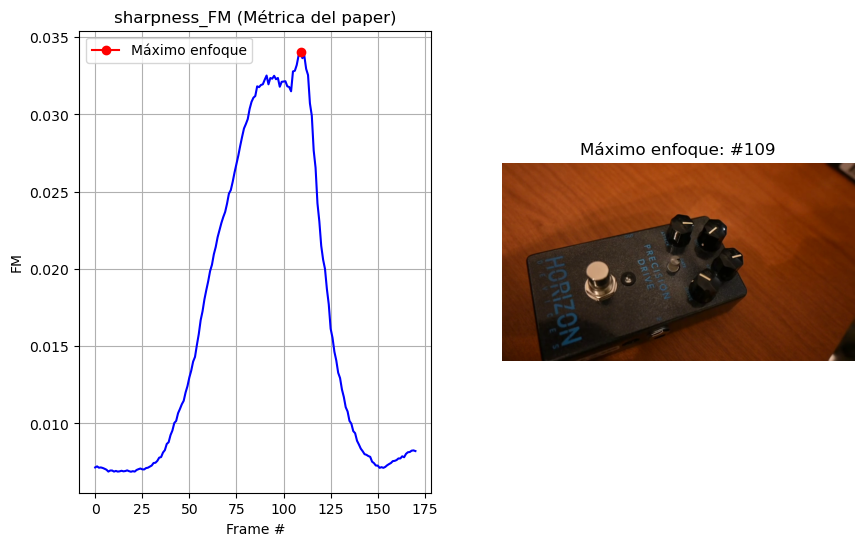

In [22]:
plt.figure(figsize=(10, 6))

# Subplot 1: Curva sharpness_FM
plt.subplot(1, 2, 1)
plt.plot(mask_sharpness_FW_values, color = 'blue')
plt.plot(max_index_FM,max(mask_sharpness_FW_values), color = 'red', marker = 'o', label = "Máximo enfoque")
plt.title("sharpness_FM (Métrica del paper)")
plt.xlabel("Frame #")
plt.ylabel("FM")
plt.legend(loc = 'best')
plt.grid(True)

# Subplot 2: frame más enfocado según  shapness_FW
img_FW = color_frames[max_index_FM].copy()
plt.subplot(1, 2, 2)
plt.imshow(img_FW)
plt.title(f"Máximo enfoque: #{max_index_FM}")
plt.axis('off')

In [23]:
# Lista de alfas a considerar
alphas    = [0, 0.5, 1.0, 1.5, 2.0, 2.5]
results   = []
FM_scores = []

# Aplicamos unsharp con cada alpha y calculamos la métrica
for alpha in alphas:
  sharpened        = [sharpness_FW(unsharp_mask(f,alpha=alpha)) for f in frames]
  FM               = np.argmax(sharpened)
  results.append(sharpened)
  FM_scores.append(FM)

**Visualización de Resultados**

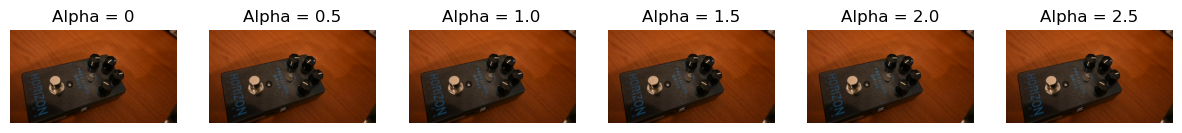

In [24]:
# Crear una figura para mostrar las imágenes
fig, axes = plt.subplots(1, len(alphas), figsize=(15, 5))

# Mostrar las imágenes con diferentes valores de alpha
for i in range(len(alphas)):
    img_FW = color_frames[FM_scores[i]].copy()

    axes[i].imshow(img_FW)
    axes[i].set_title(f'Alpha = {alphas[i]}')
    axes[i].axis('off')

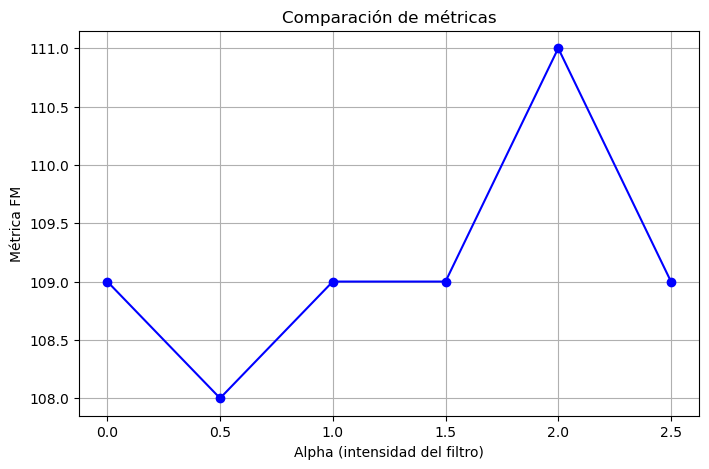

In [25]:
# Comparación de metricas
plt.figure(figsize=(8,5))
plt.plot(alphas, FM_scores, color='b', marker ='o')
plt.xlabel('Alpha (intensidad del filtro)')
plt.ylabel('Métrica FM')
plt.title('Comparación de métricas')
plt.grid(True)
plt.show()

Según la comparación de métricas para distintos valores de alfa, se puede observar lo siguiente:

* Respecto a la imagen original (alfa = 0), los valores entre 0.5 y 1.0 producen un realce suave, con mejoras muy sutiles.
* Para valores entre 1.0 y 1.5, hay un realce moderado y natural.
* Luego, para valores entre 1.5 y 2.0, se observa un realce fuerte y bordes muy acentuados.
* Para valores mayores a 2.0, se ve que la métrica empeora.